### Alex Kramer - Northeastern - Summer 2023 - Homework 3 - DS 5110

Bioinformatics is an interdisciplinary field that combines biology, computer science, and data science to analyze and interpret biological data. In this assignment, you are a data scientist tasked with exploring gene-disease association catalogued by DisGeNET: a platform for studying the connection between genes and human disease. (To say that a gene and a disease are associated means that there is believed to be some connection between a genetic variant and the risk of developing that disease.)

First, take the tables we have given you and construct a relational database. I recommend you build a simple two-table SqLite database, using the csvsql command that comes with csvkit – a library you can install using conda. Next, open DBeaver or a database client of your own choosing and establish a connection to your database. Write and refine queries that answer the questions listed below. Pull the resulting tables into a Pandas DataFrame to build a visualization of your data. To carry out this assignment, you should know basic SQL syntax: SELECT, DISTINCT, FROM, JOIN, WHERE, GROUP BY, ORDER BY, LIMIT, IN, and AND. You may do some of your processing with SQL, and some using Python. How you split up the work is up to you. But I found it easiest to do most of the work with SQL.

In [39]:
# import packages for homework 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import sqlite3

In [40]:
# Connect to your database
bio_info = sqlite3.connect('bioinfo_all.db')

For this assignment, I created a 'view' in DBeaver for each of the tables I needed to access. This kept my python code to include shortern amounts of SQL queries. Instead of uploading a bunch of screenshots of my DBeaver code, I have provided the SQL code above to create the views I used. 

### Question 1
Investigate the pace of progress in biomedical research. How many gene-disease
associations were cataloged and how many total papers were published between 1960
and the present? Plot the cumulative total number of associations and published papers
year by year from 1960 to the present. (Hint: use the last_year column). Write a short
essay explaining how the completion of the Human Genome Project in 2003 (which
began the “Post-Genomic Era”) accelerated research in gene-disease associations. (This
can be embedded in your code). Your visualization should reinforce your historical
summary

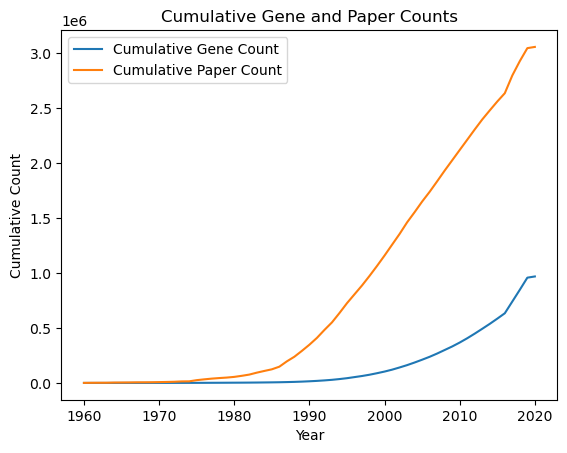

In [48]:
df = pd.read_sql("SELECT * FROM Paper_Gene_Count", bio_info)

#df = pd.read_csv('paper-count-q1.csv')

# dataframe type
df['year'] = pd.to_datetime(df['year'], format='%Y')

# sort
df = df.sort_values('year')

# find sums
df['cumulative_gene_count'] = df['gene_count'].cumsum()
df['cumulative_paper_count'] = df['paper_count'].cumsum()

# plot
plt.plot(df['year'], df['cumulative_gene_count'], label='Cumulative Gene Count')
plt.plot(df['year'], df['cumulative_paper_count'], label='Cumulative Paper Count')
plt.xlabel('Year')
plt.ylabel('Cumulative Count')
plt.title('Cumulative Gene and Paper Counts')
plt.legend()
plt.show()

In 2003 the Human Genome Project was seen as complete with 90% of the human genomes collected. This has led to a delayed spike in new genes discovered in the following years.

### Question 2
What 10 genes have the greatest number of associations? Report the gene symbol and name, and the number of associations and total number of publications. No plot is required – a simple table is sufficient. Repeat your analysis – but now find the diseases with the most number of associations. Exclude disease_type = ‘group’ from your analysis. (Do you notice a common theme?)

SQL:
DROP VIEW IF EXISTS final_top_genes;
CREATE VIEW final_top_genes AS
SELECT
    gene_symbol,
    gene_name,
    num_pubs
FROM
    disgenet
GROUP BY
    gene_symbol, gene_name
ORDER BY
    num_pubs DESC
LIMIT 10;

In [58]:
#read_sql in ('SELECT * FROM test', bio_info) final_top_genes
final_top_diseases = pd.read_sql("SELECT * FROM final_top_diseases", bio_info)
final_top_genes = pd.read_sql("SELECT * FROM final_top_genes", bio_info)

print('Top Diseases\n')
print(final_top_diseases.head(10))

print('Top Genes\n')
print(final_top_genes.head(10))

Top Diseases

                                        disease_name  \
0                   Age related macular degeneration   
1                        ALPORT SYNDROME 1, X-LINKED   
2                          ACNE INVERSA, FAMILIAL, 3   
3    6-pyruvoyl-tetrahydropterin synthase deficiency   
4  ALPHA-THALASSEMIA/MENTAL RETARDATION SYNDROME,...   
5                         AICARDI-GOUTIERES SYNDROME   
6                                  Abnormal behavior   
7                         AICARDI-GOUTIERES SYNDROME   
8             ALPORT SYNDROME 2, AUTOSOMAL RECESSIVE   
9                                   Aarskog syndrome   

                                           gene_name gene_symbol  num_pubs  
0           age-related maculopathy susceptibility 2       ARMS2     199.0  
1                     collagen type IV alpha 5 chain      COL4A5      83.0  
2                                       presenilin 1       PSEN1      64.0  
3                6-pyruvoyltetrahydropterin synthase         

### Question 3
If we think of genes and diseases as vertices and associations as edges linking genes to
disease, we can apply the tools of network analysis to explore the topology of this vast
network. The degree of a node is the number of associations that gene or disease is
involved in. Plot the degree distribution of genes on a log-log scale to show that it is a
scale-free distribution. Overlay the degree distribution of diseases. They, too, follow a
scale-free distribution!

/var/folders/vs/p96pv22d4p73j4j84xb9k3zr0000gn/T/ipykernel_1185/3946924379.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([int(10**tick) for tick in plt.gca().get_yticks()])


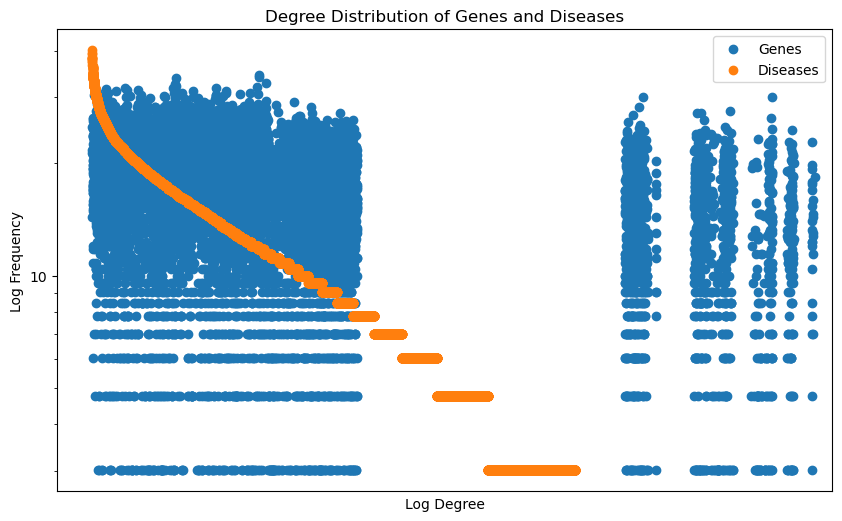

In [59]:
df = pd.read_sql("SELECT * FROM disgenet", bio_info)

gene_degree = df['gene_id'].value_counts()
disease_degree = df['disease_name'].value_counts()
gene_degree_log = np.log10(gene_degree)
disease_degree_log = np.log10(disease_degree)

# figure size
plt.figure(figsize=(10, 6))

# plot the scatter plot
plt.scatter(gene_degree_log.index, gene_degree_log, label='Genes')
plt.scatter(disease_degree_log.index, disease_degree_log, label='Diseases')
plt.xlabel('Log Degree')
plt.ylabel('Log Frequency')
plt.title('Degree Distribution of Genes and Diseases')
plt.yscale('log')
plt.gca().set_yticklabels([int(10**tick) for tick in plt.gca().get_yticks()])

# legend
plt.legend()
plt.xticks([])
plt.show()


### Question 4:
Identify the 300+ genes that are strongly associated with Alzheimer’s Disease. We
define “strongly associated” as having an Evidence Index (EI) >= 0.667 based on 11 or
more publications. (The evidence index is the fraction of publications that conclude
that there IS a link between the gene and the disease.). Output the table of genes – it is
ok to show the top 10 genes with the most publications

SQL:
DROP VIEW IF EXISTS alzheimers;
CREATE VIEW alzheimers AS
SELECT *
FROM disgenet
WHERE disease_name == "Alzheimer's Disease"
AND EI >= 0.667 AND num_pubs >= 11
ORDER BY num_pubs DESC;

In [60]:
alz = pd.read_sql("SELECT * FROM alzheimers", bio_info)
print("Top 10 Genes Associated with Alzheimer's\n")
print(alz.head(10))

Top 10 Genes Associated with Alzheimer's

   gene_id gene_symbol                                      gene_name    DSI  \
0    348.0        APOE                               apolipoprotein E  0.338   
1    351.0         APP                 amyloid beta precursor protein  0.422   
2   4137.0        MAPT             microtubule associated protein tau  0.445   
3   5663.0       PSEN1                                   presenilin 1  0.469   
4  23621.0       BACE1                               beta-secretase 1  0.559   
5     43.0        ACHE  acetylcholinesterase (Cartwright blood group)  0.445   
6    590.0        BCHE                          butyrylcholinesterase  0.447   
7   1437.0        CSF2                    colony stimulating factor 2  0.330   
8   3918.0       LAMC2                        laminin subunit gamma 2  0.389   
9    627.0        BDNF              brain derived neurotrophic factor  0.345   

     DPI         disease_name disease_type      EI  score  first_year  \
0  0

### Question 5:
For these 300+ genes, plot the Disease Pleiotropy Index (DPI) vs. the Disease Specificity
Index (DSI) as a scatter plot. Use plt.text(x,y,label) to annotate your scatter plot with
the symbols for four genes: APOE, APP, MAPT, and CALHM1. The first three are
mentioned in the most publications. CALHM1 has the highest DSI – is very specific to
Alzheimer’s – and stands out as an interesting outlier among these 300 genes! Setting
the size of the marker to the number of publications, and the color to the Evidence
Index (EI) makes for a very interesting plot – give it a try. My call to the scatter plot
function looks like this:
plt.scatter(alz.DSI, alz.DPI, c=alz.EI, s=alz.num_pubs, cmap='viridis')

Same SQL view as used above.

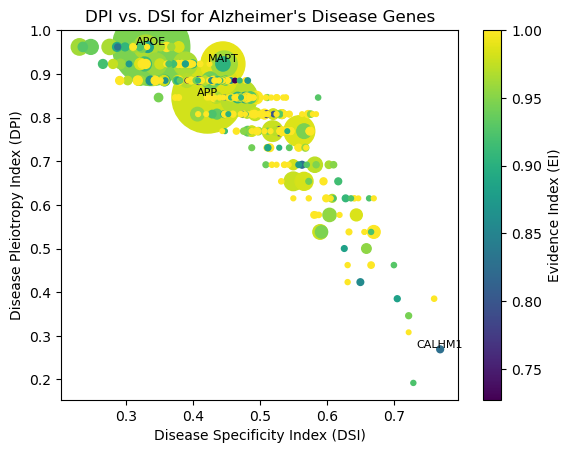

In [62]:
alz = pd.read_sql("SELECT * FROM alzheimers", bio_info)


# create the scatter plot (code given in HW)
plt.scatter(alz.DSI, alz.DPI, c=alz.EI, s=alz.num_pubs, cmap='viridis')

# lable the specific
genes_to_annotate = ['APOE', 'APP', 'MAPT', 'CALHM1']
annotations = ['APOE', 'APP', 'MAPT', 'CALHM1']

for gene, annotation in zip(genes_to_annotate, annotations):
    gene_data = alz[alz['gene_symbol'] == gene]
    x = gene_data.DSI.item()
    y = gene_data.DPI.item()
    plt.text(x, y, annotation, fontsize=8, ha='center', va='bottom')

# labels & title
plt.xlabel('Disease Specificity Index (DSI)')
plt.ylabel('Disease Pleiotropy Index (DPI)')
plt.title('DPI vs. DSI for Alzheimer\'s Disease Genes')
cbar = plt.colorbar()
cbar.set_label('Evidence Index (EI)')
plt.show()

### Question 6:
According to GO, what biological processes are these Alzheimer’s-linked genes most
frequently involved in? Provide a table with the GO ID, the qualifier, the Go Term, and the number of genes that are involved in that process. You’ll want to use the DISTINCT
keyword in your select, because the same gene may have been annotated with the
same GO Term multiple times according to difference evidence codes.

In [64]:
go_table = pd.read_sql("SELECT * FROM GO_table_q6", bio_info)
#go_table = bio_info.read_sql("SELECT * FROM GO_table_q6", con) # replace all of the df's with data
print("What biological processes are these Alzheimer’s-linked genes most frequently involved in?\n")
print('Top 10')
print(go_table.head(10))

What biological processes are these Alzheimer’s-linked genes most frequently involved in?

Top 10
                     go_term   qualifier  Number of Genes
0            protein binding     enables              275
1                    cytosol  located_in              141
2            plasma membrane  located_in              127
3                    nucleus  located_in              103
4                  cytoplasm  located_in              102
5       extracellular region  located_in               94
6      extracellular exosome  located_in               87
7                   membrane  located_in               85
8                nucleoplasm  located_in               84
9  identical protein binding     enables               81


### Question 7:
Take the 300+ Alzheimer’s-linked genes you found earlier and now figure out what other
diseases these genes are also associated with. Retain the requirement that EI >= 0.667
and num_pubs >= 11. Also, again exclude diseases where disease_type = ‘group’. Rank
the diseases by how many Alzheimer’s-linked genes are involved and report the top 10
diseases in a table.

In [65]:
ques_7 = pd.read_sql("SELECT * FROM alz_association_disease", bio_info)
#ques_7 = bio_info.read_sql("SELECT * FROM alz_association_disease", con)
print('Top 10 Diseases with genes related to Alzheimer\n')
print(ques_7.head(10))

Top 10 Diseases with genes related to Alzheimer

                     disease_name  Number of Genes
0             Alzheimer's Disease             3122
1    Malignant neoplasm of breast             2073
2                Breast Carcinoma             2051
3             Tumor Cell Invasion             1939
4             Neoplasm Metastasis             1906
5                  Carcinogenesis             1831
6                 Liver carcinoma             1788
7            Colorectal Carcinoma             1727
8  Malignant neoplasm of prostate             1621
9              Prostate carcinoma             1602


### Open Research Initiative
Ask a research question of this amazing catalog, produce a visualization of your answer, and caption your visualization inside a single ONE-page PowerPoint slide. (A template will be provided.) You will be graded on how interesting we find your question, how effectively you visualize your answer, and the clarity of your caption. These PowerPoint slides will be compiled for a future class discussion.

#### Research Question: What are the diseases with the highest publication count? Do the genes across these diseases have any overlap? If so, how much?

I was unable to use SQL within Python to complete my research. Instead, I used DBeaver to create a table that showed the top 10 diseases by number of publications (top_diseases_numpub_final.csv), this file can be found in my ZIP file upload. For creating my network (figure 2), I used a simple SQL query to pull in each diseases' gene symbols associated with it. I then moved each of these into a CSV called final-network-gXd.csv. This file is attached in my submission

DBeaver // SQL Query:

DROP VIEW IF EXISTS top_10_disease_by_num_pub;
CREATE VIEW top_10_disease_by_num_pub AS
SELECT d.disease_name, d.num_pubs
FROM disgenet d
JOIN go_human g ON d.gene_id = g.gene_id
GROUP BY d.disease_name
ORDER BY d.num_pubs DESC
LIMIT 10;

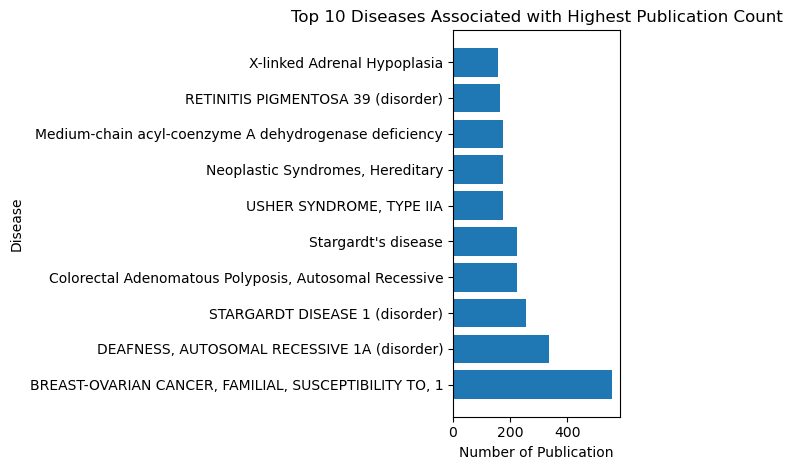

In [29]:
# Read the CSV file into a DataFrame 
df = pd.read_csv('top_diseases_numpub_final.csv')

# pull disease name & num_pubs
diseases = df['disease_name']
publication_counts = df['num_pubs']

# plot & label
plt.barh(diseases, publication_counts)
plt.xlabel('Number of Publication')
plt.ylabel('Disease')
plt.title('Top 10 Diseases Associated with Highest Publication Count')
plt.tight_layout()
plt.show()


SQL Code:
SELECT d.gene_symbol, d.gene_name, d.num_pubs, d.gene_id 
FROM disgenet d
JOIN go_human g ON d.gene_id = g.gene_id
WHERE d.disease_name = "X-linked Adrenal Hypoplasia" <- I manually went through each disease above to pull
GROUP BY d.gene_symbol, d.gene_name
ORDER BY d.num_pubs DESC;

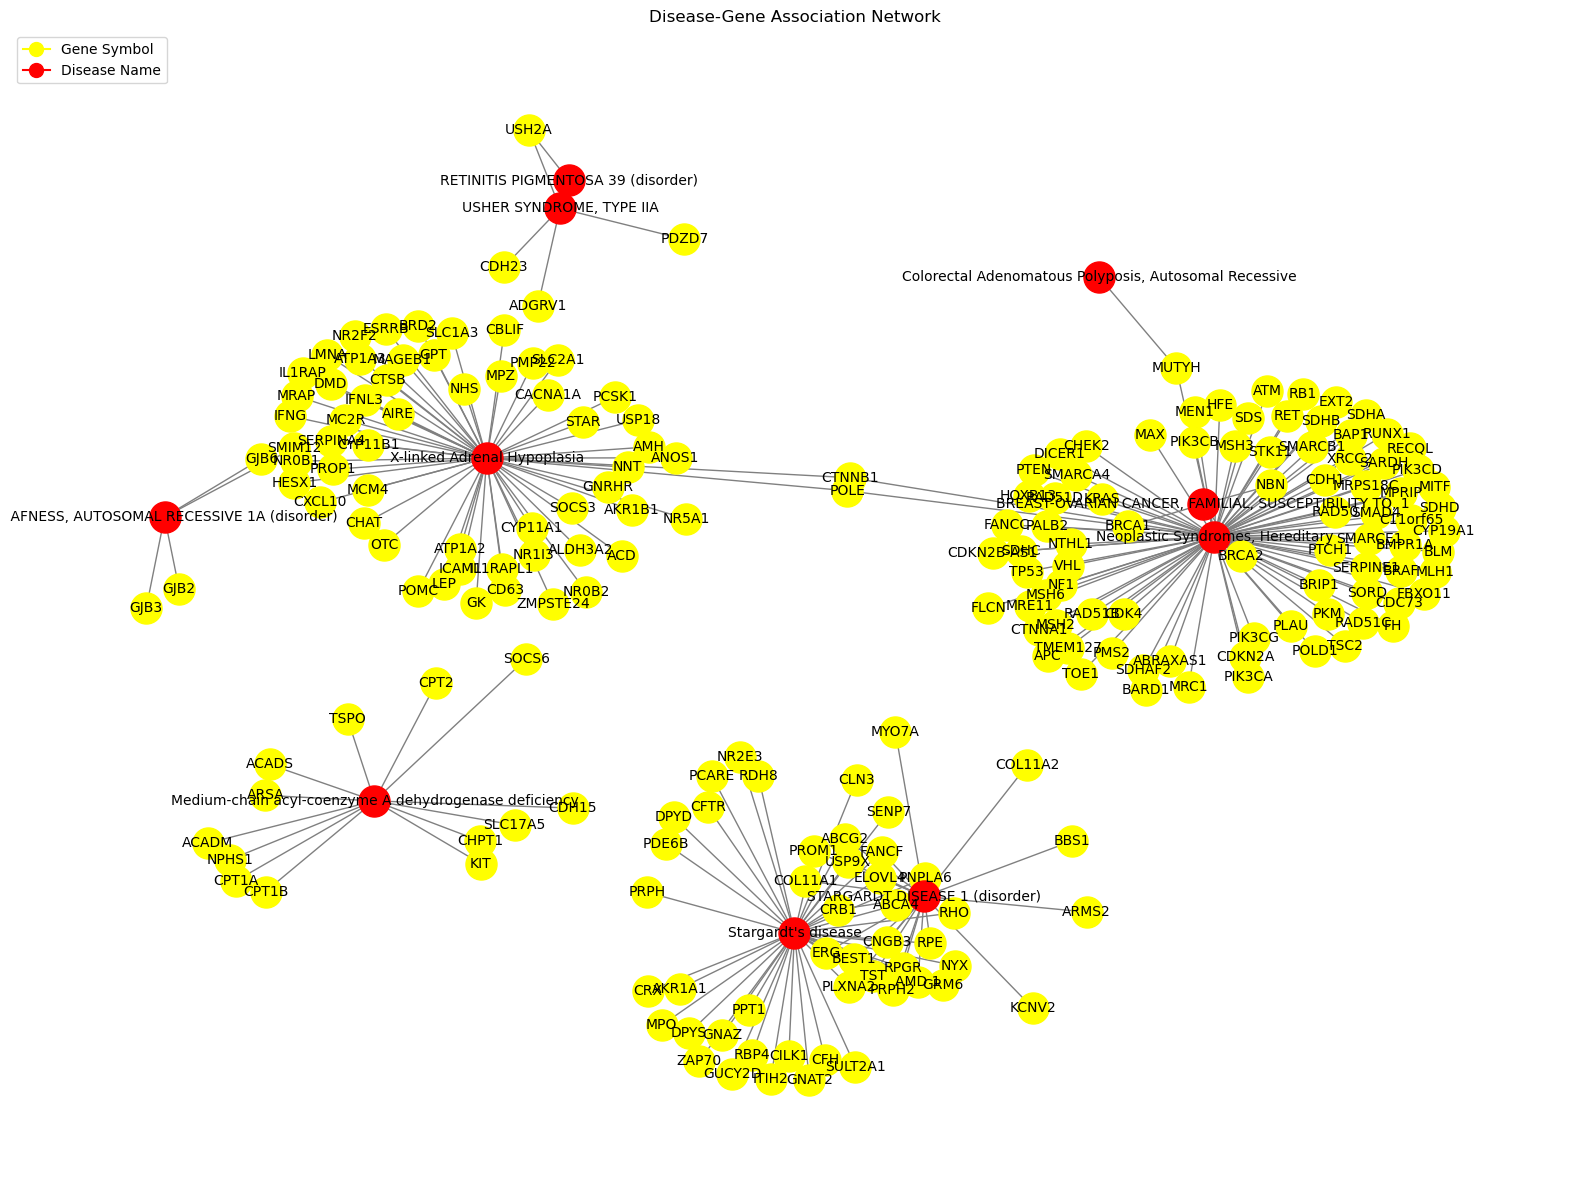

In [18]:
# Read the CSV file into a DataFrame
df = pd.read_csv('final-network-gXd.csv')

# Create an empty graph
G = nx.Graph()

# Create dictionaries to store the node types (genes or diseases) and corresponding colors
node_types = {}
colors = {}

# Iterate over the rows of the DataFrame and add edges to the graph
for _, row in df.iterrows():
    disease = row[0]  # Access the first column (disease name)
    gene = row[1]  # Access the second column (gene symbol)
    G.add_edge(disease, gene)

    # Assign node types and colors
    node_types[disease] = 'Disease'
    node_types[gene] = 'Gene'
    colors[disease] = 'yellow'
    colors[gene] = 'red'

# set up graph
pos = nx.spring_layout(G, k=0.2, iterations=50)
plt.figure(figsize=(16, 12))

# draw gene symbols with yellow nodes and disease with red nodes
disease_nodes = [node for node, node_type in node_types.items() if node_type == 'Disease']
nx.draw_networkx_nodes(G, pos, nodelist=disease_nodes, node_color='yellow', node_size=500)
gene_nodes = [node for node, node_type in node_types.items() if node_type == 'Gene']
nx.draw_networkx_nodes(G, pos, nodelist=gene_nodes, node_color='red', node_size=500)

# draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray')

# labels
nx.draw_networkx_labels(G, pos, font_size=10)
plt.legend(handles=[plt.Line2D([], [], marker='o', color='yellow', markersize=10, label='Gene Symbol'),
                    plt.Line2D([], [], marker='o', color='red', markersize=10, label='Disease Name')],
           loc='upper left')


plt.title('Disease-Gene Association Network')
plt.axis('off')
plt.tight_layout()
plt.show()

From this network we are clearly able to see the diseases (red nodes), and how they connect to the genes commonly associated. When looking at the bar chart above we are able to see which disease have the most publicans. After creating the network I was able to dive into which genes have overlap across diseases. What stands out to me the most is the overlap between Neoplastic Syndromes and Breast Cancer. 